In [1]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date
import yaml

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.signal import savgol_filter
import sklearn
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
import keras_tuner as kt
tf.__version__

'2.6.0'

In [2]:
%load_ext skip_kernel_extension

In [3]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
convert_from_differencing,
make_multiple_predictions,
calculate_r2_scores,
apply_differencing,
create_split,
apply_savgol_filter)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
plot_multiple_predictions,
plot_evaluation
)

In [4]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
tf.random.set_seed(2022)

In [5]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [6]:
with open('parameter.yaml','r') as f:
    parameter_dict = yaml.safe_load(f)
parameter_dict.keys()

dict_keys(['generation', 'share', 'time', 'weather'])

Benchmark data set

In [7]:
# bench_df = pd.read_csv("energy_dataset.csv")
# bench_df = set_timestamp_index(bench_df,"time")
# bench_df = bench_df['price day ahead']
# bench_df = bench_df.rename('Benchmark')

Base data set

In [8]:
energy_df = pd.read_csv("energy_dataset_cleaned.csv")
energy_df = set_timestamp_index(energy_df,"Unnamed: 0")

In [9]:
weather_df = pd.read_csv("weather_dataset_madrid.csv")
weather_df = set_timestamp_index(weather_df,"Unnamed: 0")

In [10]:
additional_feature_df = pd.read_csv("additional_feature_dataset.csv")
additional_feature_df = set_timestamp_index(additional_feature_df,"Unnamed: 0")

In [11]:
transfer_df = pd.read_csv("transfer_dataset_cleaned.csv")
transfer_df = set_timestamp_index(transfer_df,"Unnamed: 0")

In [12]:
time_df = pd.read_csv("time_dataset.csv")
time_df = set_timestamp_index(time_df,"Unnamed: 0")

In [13]:
base_df = pd.concat([energy_df,weather_df,additional_feature_df,transfer_df],axis=1)

In [14]:
base_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,share hydro run-of-river and poundage,share hydro water reservoir,share nuclear,share other,share other renewable,share solar,share waste,share wind onshore,energy_exchange_PT,energy_exchange_FR
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0.037202,0.067219,0.251177,0.001522,0.002584,0.001734,0.006938,0.225762,-285.0,933.0
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0.036271,0.059602,0.255087,0.001546,0.002552,0.001797,0.007010,0.211733,53.0,1119.0
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0.036311,0.051164,0.264928,0.001605,0.002724,0.001866,0.007315,0.203799,682.0,954.0
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0.037624,0.030885,0.281410,0.001705,0.002973,0.001982,0.007572,0.207668,976.0,13.0
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0.038708,0.029245,0.288262,0.001747,0.003006,0.001706,0.007677,0.200447,1011.0,-238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0.042968,0.183078,0.229907,0.002385,0.003596,0.003218,0.010486,0.117850,-1102.0,-3232.0
2018-12-31 20:00:00+01:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0.046484,0.155912,0.240907,0.002459,0.003768,0.001309,0.011105,0.130409,-1099.0,-3377.0
2018-12-31 21:00:00+01:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0.047859,0.118022,0.253304,0.002543,0.003919,0.001292,0.011923,0.146037,-1329.0,-3460.0
2018-12-31 22:00:00+01:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,...,0.049587,0.090909,0.267056,0.002682,0.004088,0.001363,0.012616,0.157640,-937.0,-3429.0


Apply Savitzky Golay Filter 

In [15]:
savgol_df = apply_savgol_filter(base_df,5,1)

In [16]:
savgol_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,share hydro run-of-river and poundage,share hydro water reservoir,share nuclear,share other,share other renewable,share solar,share waste,share wind onshore,energy_exchange_PT,energy_exchange_FR
2015-01-01 00:00:00+01:00,451.8,355.8,5130.2,4942.8,160.6,753.4,1038.2,1932.8,7096.4,43.0,...,0.036351,0.068556,0.248074,0.001503,0.002515,0.001792,0.006894,0.220821,-215.6,1245.8
2015-01-01 01:00:00+01:00,446.9,320.0,4899.2,4684.2,159.6,1004.3,1012.6,1609.1,7096.8,43.0,...,0.036787,0.058089,0.258123,0.001564,0.002641,0.001804,0.007098,0.215351,135.9,901.0
2015-01-01 02:00:00+01:00,442.0,284.2,4668.2,4425.6,158.6,1255.2,987.0,1285.4,7097.2,43.0,...,0.037224,0.047623,0.268173,0.001625,0.002768,0.001817,0.007302,0.209882,487.4,556.2
2015-01-01 03:00:00+01:00,434.6,254.0,4507.0,4179.4,157.4,1504.4,967.2,1054.2,7097.6,43.0,...,0.037641,0.040312,0.276523,0.001675,0.002862,0.001751,0.007466,0.202846,759.2,178.6
2015-01-01 04:00:00+01:00,425.0,222.8,4275.8,3902.0,157.4,1742.0,957.6,892.2,7098.0,43.0,...,0.038432,0.035491,0.284933,0.001726,0.002971,0.001676,0.007622,0.197313,933.8,-297.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,295.2,0.0,7277.0,2560.6,175.0,35.4,1134.8,3653.4,6073.4,61.6,...,0.045304,0.144767,0.242519,0.002459,0.003762,0.014147,0.011411,0.123036,-871.0,-2831.8
2018-12-31 20:00:00+01:00,294.2,0.0,7211.0,2502.6,172.2,32.2,1142.8,3534.2,6074.0,61.6,...,0.046237,0.140950,0.245790,0.002491,0.003795,0.003520,0.011490,0.133507,-1213.6,-2892.2
2018-12-31 21:00:00+01:00,293.6,0.0,7077.6,2415.0,169.2,53.6,1130.4,3070.4,6074.6,61.6,...,0.046838,0.124501,0.251984,0.002553,0.003888,0.001711,0.011766,0.142690,-888.4,-3382.8
2018-12-31 22:00:00+01:00,291.9,0.0,6868.1,2295.3,165.1,85.7,1112.8,2254.1,6075.1,61.1,...,0.048012,0.096302,0.262367,0.002638,0.004015,0.001347,0.012359,0.154146,-646.8,-3424.8


In [17]:
def apply_rolling_mean_std(df, window):
    mean_df = df.rolling(window).mean()
    std_df = df.rolling(window).std()
    rename_map_mean = {}
    rename_map_std = {}
    for col in df.columns:
        rename_map_mean[col] = col + "_mean_" + str(window)
        rename_map_std[col] = col + "_std_" + str(window)
    mean_df.rename(columns=rename_map_mean,inplace=True)
    std_df.rename(columns=rename_map_std,inplace=True)
    stat_df = pd.concat([mean_df,std_df],axis=1)
    return stat_df

In [18]:
base_24 = apply_rolling_mean_std(savgol_df,24)
# base_48 = apply_rolling_mean_std(savgol_df,48)
# base_168 = apply_rolling_mean_std(savgol_df,24*7)
# base_336 = apply_rolling_mean_std(savgol_df,24*14)

In [19]:
extended_df = pd.concat([savgol_df,base_24],axis=1)#,base_48,base_168,base_336
extended_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,share hydro run-of-river and poundage_std_24,share hydro water reservoir_std_24,share nuclear_std_24,share other_std_24,share other renewable_std_24,share solar_std_24,share waste_std_24,share wind onshore_std_24,energy_exchange_PT_std_24,energy_exchange_FR_std_24
2015-01-01 00:00:00+01:00,451.8,355.8,5130.2,4942.8,160.6,753.4,1038.2,1932.8,7096.4,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+01:00,446.9,320.0,4899.2,4684.2,159.6,1004.3,1012.6,1609.1,7096.8,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00+01:00,442.0,284.2,4668.2,4425.6,158.6,1255.2,987.0,1285.4,7097.2,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00+01:00,434.6,254.0,4507.0,4179.4,157.4,1504.4,967.2,1054.2,7097.6,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 04:00:00+01:00,425.0,222.8,4275.8,3902.0,157.4,1742.0,957.6,892.2,7098.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,295.2,0.0,7277.0,2560.6,175.0,35.4,1134.8,3653.4,6073.4,61.6,...,0.003066,0.031998,0.022877,0.000121,0.000362,0.053973,0.001485,0.045054,1105.881379,257.664327
2018-12-31 20:00:00+01:00,294.2,0.0,7211.0,2502.6,172.2,32.2,1142.8,3534.2,6074.0,61.6,...,0.003056,0.031341,0.023036,0.000118,0.000367,0.053948,0.001521,0.043374,1070.539548,262.176290
2018-12-31 21:00:00+01:00,293.6,0.0,7077.6,2415.0,169.2,53.6,1130.4,3070.4,6074.6,61.6,...,0.003042,0.029905,0.023035,0.000115,0.000369,0.053933,0.001542,0.041417,993.003698,305.871430
2018-12-31 22:00:00+01:00,291.9,0.0,6868.1,2295.3,165.1,85.7,1112.8,2254.1,6075.1,61.1,...,0.003043,0.028474,0.023000,0.000117,0.000369,0.053931,0.001546,0.039358,908.183527,347.789541


Apply Differencing 

In [20]:
diff_df = apply_differencing(extended_df)

In [21]:
diff_df

,generation biomass_diff,generation fossil brown coal/lignite_diff,generation fossil gas_diff,generation fossil hard coal_diff,generation fossil oil_diff,generation hydro pumped storage_diff,generation hydro run-of-river and poundage_diff,generation hydro water reservoir_diff,generation nuclear_diff,generation other_diff,...,share hydro run-of-river and poundage_std_24_diff,share hydro water reservoir_std_24_diff,share nuclear_std_24_diff,share other_std_24_diff,share other renewable_std_24_diff,share solar_std_24_diff,share waste_std_24_diff,share wind onshore_std_24_diff,energy_exchange_PT_std_24_diff,energy_exchange_FR_std_24_diff
2015-01-01 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+01:00,-4.9,-35.8,-231.0,-258.6,-1.0,250.9,-25.6,-323.7,0.4,7.105427e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00+01:00,-4.9,-35.8,-231.0,-258.6,-1.0,250.9,-25.6,-323.7,0.4,7.105427e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00+01:00,-7.4,-30.2,-161.2,-246.2,-1.2,249.2,-19.8,-231.2,0.4,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 04:00:00+01:00,-9.6,-31.2,-231.2,-277.4,0.0,237.6,-9.6,-162.0,0.4,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-1.6,0.0,129.2,-16.2,-2.0,-54.6,20.0,162.8,0.8,-7.105427e-15,...,8.112464e-07,0.000222,0.000367,-0.000002,6.953118e-06,-0.000023,0.000043,-0.000946,-9.727409,2.020181
2018-12-31 20:00:00+01:00,-1.0,0.0,-66.0,-58.0,-2.8,-3.2,8.0,-119.2,0.6,7.105427e-15,...,-1.037370e-05,-0.000657,0.000159,-0.000003,4.981921e-06,-0.000026,0.000035,-0.001680,-35.341832,4.511963
2018-12-31 21:00:00+01:00,-0.6,0.0,-133.4,-87.6,-3.0,21.4,-12.4,-463.8,0.6,-7.105427e-15,...,-1.420532e-05,-0.001436,-0.000001,-0.000003,2.035615e-06,-0.000015,0.000022,-0.001957,-77.535850,43.695140
2018-12-31 22:00:00+01:00,-1.7,0.0,-209.5,-119.7,-4.1,32.1,-17.6,-816.3,0.5,-5.000000e-01,...,1.470704e-06,-0.001430,-0.000035,0.000002,2.191706e-07,-0.000002,0.000004,-0.002059,-84.820171,41.918111


In [22]:
time_df

,month,day,weekend,hour
2015-01-01 00:00:00+01:00,1,1,0,0
2015-01-01 01:00:00+01:00,1,1,0,1
2015-01-01 02:00:00+01:00,1,1,0,2
2015-01-01 03:00:00+01:00,1,1,0,3
2015-01-01 04:00:00+01:00,1,1,0,4
...,...,...,...,...
2018-12-31 19:00:00+01:00,12,31,0,19
2018-12-31 20:00:00+01:00,12,31,0,20
2018-12-31 21:00:00+01:00,12,31,0,21
2018-12-31 22:00:00+01:00,12,31,0,22


In [23]:
final_df = pd.concat([diff_df,time_df],axis=1)
final_df.index = final_df.index.tz_convert('Europe/Berlin')
final_df

,generation biomass_diff,generation fossil brown coal/lignite_diff,generation fossil gas_diff,generation fossil hard coal_diff,generation fossil oil_diff,generation hydro pumped storage_diff,generation hydro run-of-river and poundage_diff,generation hydro water reservoir_diff,generation nuclear_diff,generation other_diff,...,share other renewable_std_24_diff,share solar_std_24_diff,share waste_std_24_diff,share wind onshore_std_24_diff,energy_exchange_PT_std_24_diff,energy_exchange_FR_std_24_diff,month,day,weekend,hour
2015-01-01 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0
2015-01-01 01:00:00+01:00,-4.9,-35.8,-231.0,-258.6,-1.0,250.9,-25.6,-323.7,0.4,7.105427e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,1
2015-01-01 02:00:00+01:00,-4.9,-35.8,-231.0,-258.6,-1.0,250.9,-25.6,-323.7,0.4,7.105427e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,2
2015-01-01 03:00:00+01:00,-7.4,-30.2,-161.2,-246.2,-1.2,249.2,-19.8,-231.2,0.4,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,3
2015-01-01 04:00:00+01:00,-9.6,-31.2,-231.2,-277.4,0.0,237.6,-9.6,-162.0,0.4,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-1.6,0.0,129.2,-16.2,-2.0,-54.6,20.0,162.8,0.8,-7.105427e-15,...,6.953118e-06,-0.000023,0.000043,-0.000946,-9.727409,2.020181,12,31,0,19
2018-12-31 20:00:00+01:00,-1.0,0.0,-66.0,-58.0,-2.8,-3.2,8.0,-119.2,0.6,7.105427e-15,...,4.981921e-06,-0.000026,0.000035,-0.001680,-35.341832,4.511963,12,31,0,20
2018-12-31 21:00:00+01:00,-0.6,0.0,-133.4,-87.6,-3.0,21.4,-12.4,-463.8,0.6,-7.105427e-15,...,2.035615e-06,-0.000015,0.000022,-0.001957,-77.535850,43.695140,12,31,0,21
2018-12-31 22:00:00+01:00,-1.7,0.0,-209.5,-119.7,-4.1,32.1,-17.6,-816.3,0.5,-5.000000e-01,...,2.191706e-07,-0.000002,0.000004,-0.002059,-84.820171,41.918111,12,31,0,22


In [24]:
final_df.dropna(axis=0,inplace=True)
final_df

,generation biomass_diff,generation fossil brown coal/lignite_diff,generation fossil gas_diff,generation fossil hard coal_diff,generation fossil oil_diff,generation hydro pumped storage_diff,generation hydro run-of-river and poundage_diff,generation hydro water reservoir_diff,generation nuclear_diff,generation other_diff,...,share other renewable_std_24_diff,share solar_std_24_diff,share waste_std_24_diff,share wind onshore_std_24_diff,energy_exchange_PT_std_24_diff,energy_exchange_FR_std_24_diff,month,day,weekend,hour
2015-01-02 00:00:00+01:00,-17.0,-65.0,-382.4,-804.0,7.0,539.6,5.2,-730.0,2.2,2.000000e-01,...,2.482514e-05,-6.833387e-06,0.000061,0.007039,-10.714984,-139.995027,1,2,0,0
2015-01-02 01:00:00+01:00,-17.4,-64.4,-386.8,-794.8,6.8,653.8,14.0,-485.2,1.8,2.000000e-01,...,4.240463e-05,-2.172945e-07,0.000098,0.011877,30.822551,-137.450372,1,2,0,1
2015-01-02 02:00:00+01:00,-16.8,-64.0,-358.4,-767.8,5.8,653.4,27.6,-173.0,1.6,2.000000e-01,...,5.362713e-05,2.966050e-06,0.000131,0.015113,57.185727,-136.239962,1,2,0,2
2015-01-02 03:00:00+01:00,-2.8,0.0,-60.0,-34.2,-0.6,393.6,-8.6,-268.4,-0.2,-2.000000e-01,...,4.079222e-05,-2.185099e-06,0.000098,0.011281,48.396055,-132.305614,1,2,0,3
2015-01-02 04:00:00+01:00,-2.2,0.0,-0.8,-4.6,-0.6,252.0,-4.4,-67.6,-0.2,-2.000000e-01,...,2.972259e-05,-5.307524e-06,0.000070,0.008756,25.251049,-104.709844,1,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-1.6,0.0,129.2,-16.2,-2.0,-54.6,20.0,162.8,0.8,-7.105427e-15,...,6.953118e-06,-2.311809e-05,0.000043,-0.000946,-9.727409,2.020181,12,31,0,19
2018-12-31 20:00:00+01:00,-1.0,0.0,-66.0,-58.0,-2.8,-3.2,8.0,-119.2,0.6,7.105427e-15,...,4.981921e-06,-2.568360e-05,0.000035,-0.001680,-35.341832,4.511963,12,31,0,20
2018-12-31 21:00:00+01:00,-0.6,0.0,-133.4,-87.6,-3.0,21.4,-12.4,-463.8,0.6,-7.105427e-15,...,2.035615e-06,-1.475116e-05,0.000022,-0.001957,-77.535850,43.695140,12,31,0,21
2018-12-31 22:00:00+01:00,-1.7,0.0,-209.5,-119.7,-4.1,32.1,-17.6,-816.3,0.5,-5.000000e-01,...,2.191706e-07,-1.641323e-06,0.000004,-0.002059,-84.820171,41.918111,12,31,0,22


# Encode- Decoder + LSTM

Scale the input data

In [25]:
scaled_df = final_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.MinMaxScaler(feature_range=(0,1),copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [26]:
train_start = '2015-01-14'
validation_start = '2018-10-01'
test_start = '2018-11-01'
test_end = '2018-12-01'
feature = 'price actual_diff'
namespace= 'MS_EDLSTM_bigdf'
modeltype = 'EDLSTM'

batch_size = 64
num_epochs = 40

feature_df = final_df[[feature]]

data_x_train0, data_y_train0 = create_split(scaled_df,feature_df,train_start,validation_start)
data_x_val0, data_y_val0 = create_split(scaled_df,feature_df,validation_start,test_start)
data_x_test0, data_y_test0 = create_split(scaled_df,feature_df,test_start,test_end)

Convert to (sample,timestep,feature) format

In [27]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,batch_size)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,batch_size)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,batch_size)


In [28]:
print(data_x_train.shape,data_y_train.shape,idx_train.shape)
print(data_x_val.shape,data_y_val.shape,idx_val.shape)
print(data_x_test.shape,data_y_test.shape,idx_test.shape)

(32128, 336, 124) (32128, 24) (32128,)
(320, 336, 124) (320, 24) (320,)
(320, 336, 124) (320, 24) (320,)


Define LSTM Model

In [29]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(128, return_sequences=True,input_shape=(None, n_features), stateful=False))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, stateful=False))) 
    model.add(layers.BatchNormalization())  
    
    model.add(layers.LSTM(128, return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True,stateful=False)))
    model.add(layers.BatchNormalization())
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True,stateful=False)))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.LeakyReLU(alpha=0.1)))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [30]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [31]:
initial_learning_rate = 0.001

decay = initial_learning_rate/num_epochs

def scheduler(epoch,lr):
    return lr*1/(1+decay*epoch)

myLearningRate_LSTM = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [32]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM,myLearningRate_LSTM])

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
502/502 [==============================] - 75s 130ms/step - loss: 3.5039 - mae: 1.3135 - val_loss: 3.0638 - val_mae: 1.2918
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999750481212483.
502/502 [==============================] - 63s 126ms/step - loss: 1.7538 - mae: 0.8959 - val_loss: 13.0164 - val_mae: 2.8918
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009999250219521608.
502/502 [==============================] - 63s 126ms/step - loss: 1.4056 - mae: 0.8059 - val_loss: 4.7151 - val_mae: 1.7610
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009998500872736493.
502/502 [==============================] - 62s 123ms/step - loss: 1.1611 - mae: 0.7432 - val_loss: 1.2834 - val_mae: 0.8502
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0009997501295499831.
502/502 [===================

In [33]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

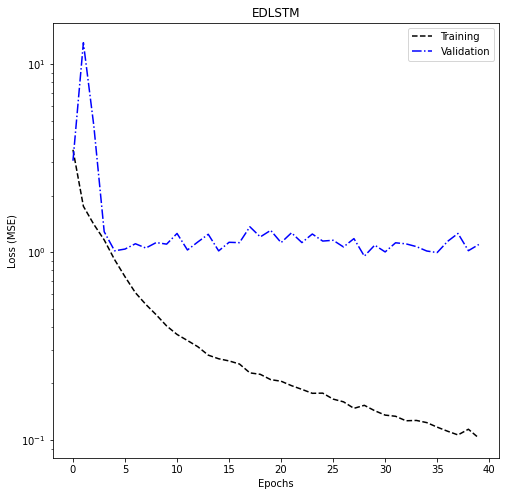

In [34]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [35]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         129536    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 128)           0

Evaluate differencing performance on validation data

In [36]:
i=0
case_val = data_x_val[i].reshape((1,data_x_val[0].shape[0], data_x_val[0].shape[1]))
Y_val_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_val).flatten(),index=pd.date_range(start=idx_val[i],freq='h',periods=24))
y_val_filtered_diff = data_y_val0.loc[Y_val_predictions_diff.index]
y_val_filtered_diff = y_val_filtered_diff.squeeze(axis=1)

In [37]:
eval_df_diff = create_eval_df(Y_val_predictions_diff,y_val_filtered_diff)

R^2 score is  0.73


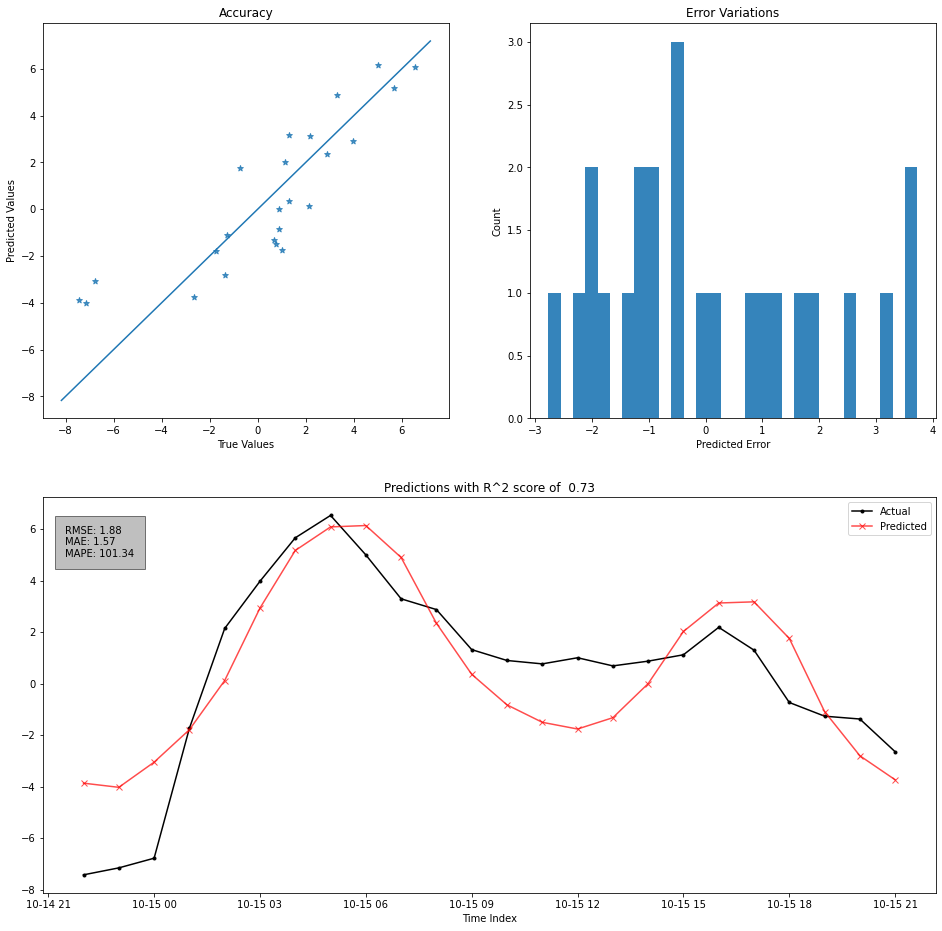

In [38]:
fig = plot_evaluation(eval_df_diff)

In [39]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,data_y_val0,feature,convert=False)

In [40]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.82


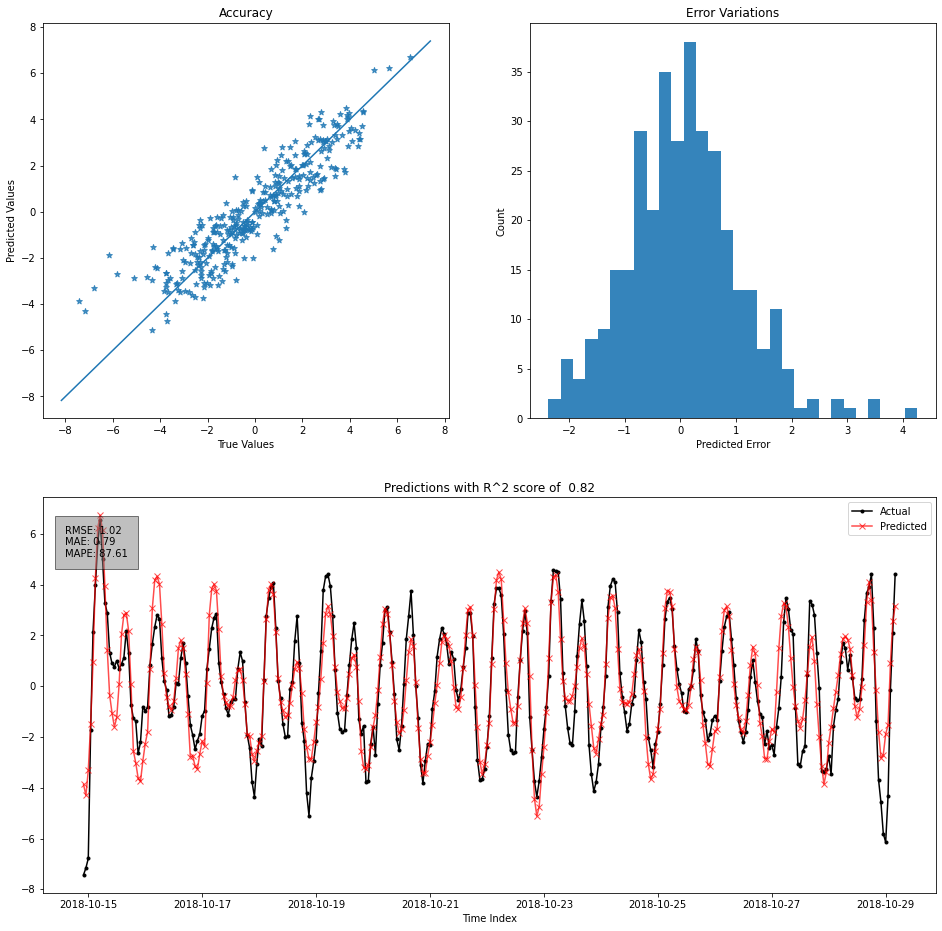

In [41]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on validation data

In [44]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,extended_df,'price actual',convert=True)

In [45]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.78


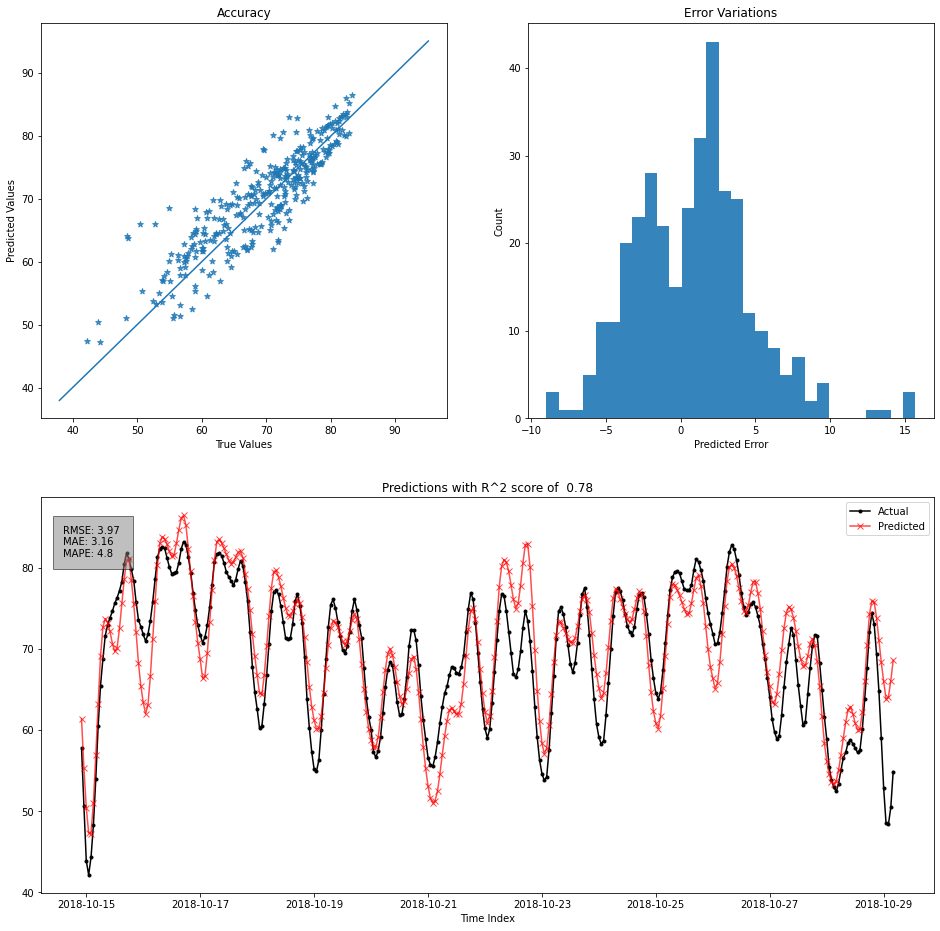

In [46]:
fig = plot_evaluation(eval_df)

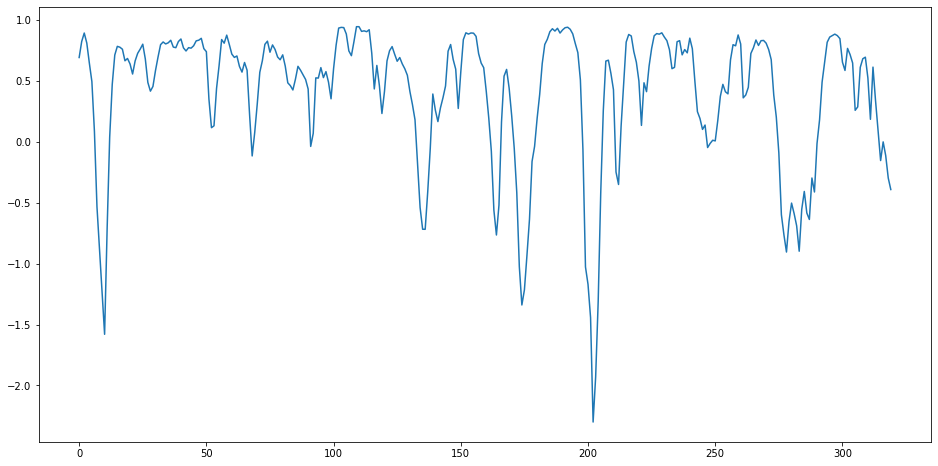

In [47]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)


Evaluate differencing Performance on test data

In [48]:
i=0
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered_diff = data_y_test0.loc[Y_test_predictions_diff.index]
y_test_filtered_diff = y_test_filtered_diff.squeeze(axis=1)

In [49]:
eval_df_diff = create_eval_df(Y_test_predictions_diff,y_test_filtered_diff)

R^2 score is  0.90


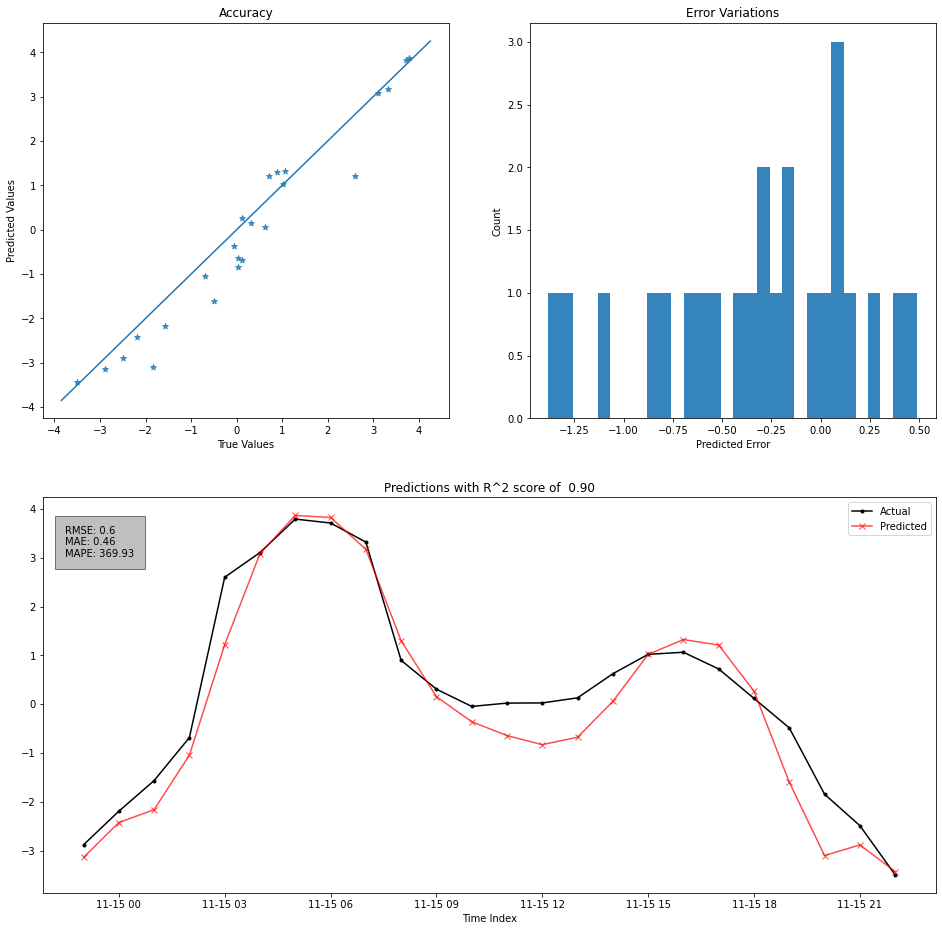

In [50]:
fig = plot_evaluation(eval_df_diff)

In [51]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,data_y_test0,feature,convert=False)

In [52]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.85


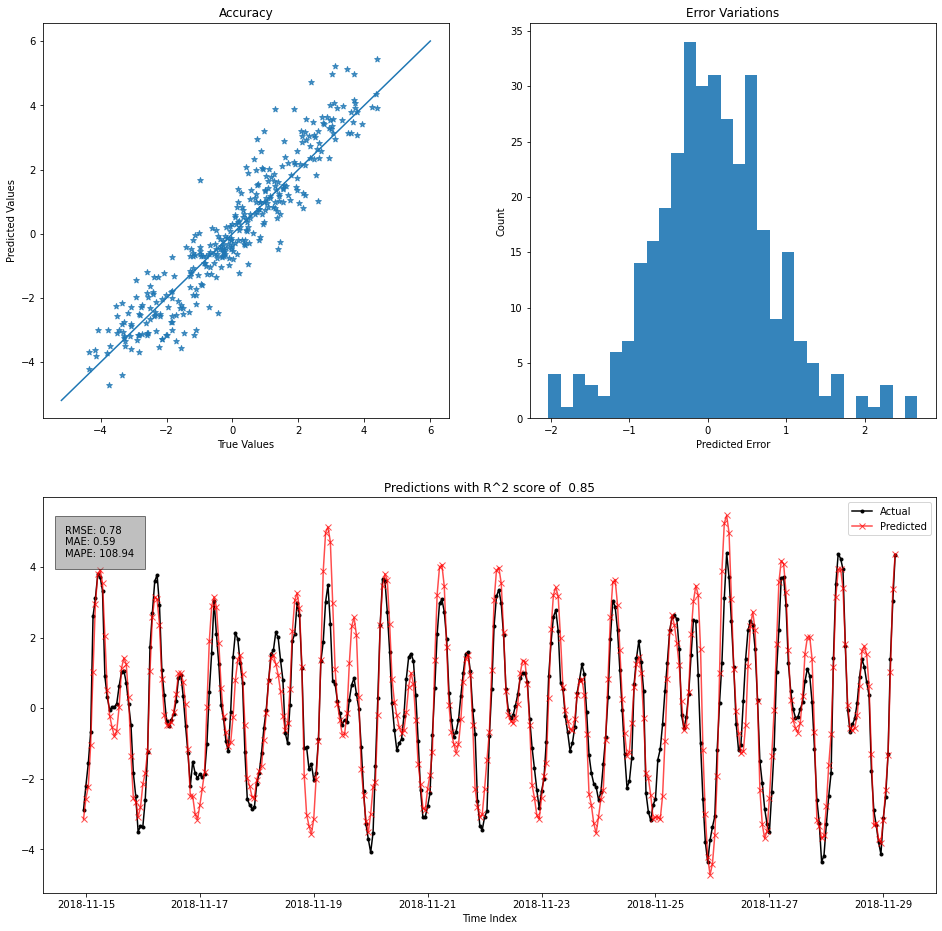

In [53]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on test data

In [56]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,extended_df,'price actual',convert=True)

In [57]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.72


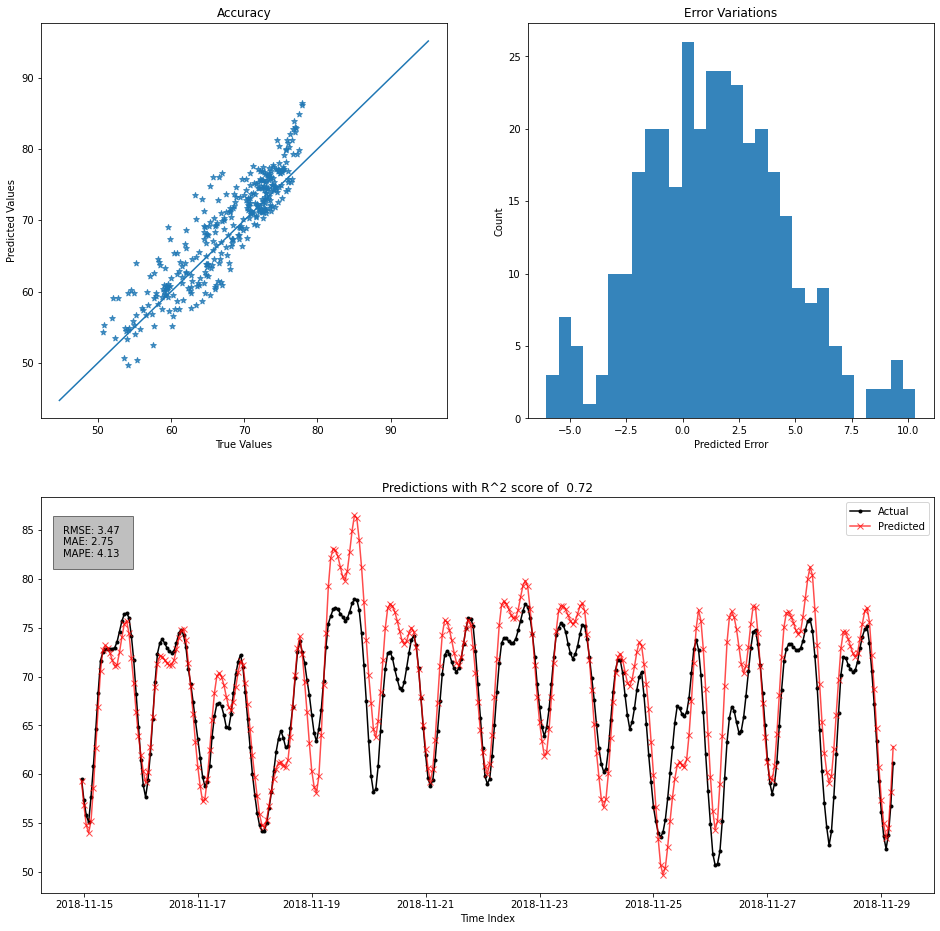

In [58]:
fig = plot_evaluation(eval_df)

In [59]:
def calculate_metrics(df_pred):
    r2_list=[]
    mpe_list= []
    mae_list= []
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            mpe = (act-pred)/act
        
            mae = sklearn.metrics.mean_absolute_error(act,pred)
            r2_list.append(r2)
            mpe_list.append(mpe.mean())
            mae_list.append(mae)
    return r2_list,mpe_list,mae_list      

def plot_metrics(df_pred):
    fig= plt.figure(figsize = (16,16))
    gs = fig.add_gridspec(3,1)
    r2_list,mpe_list,mae_list = calculate_metrics(df_pred)
    ax1 = fig.add_subplot(gs[0,0],)
    ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax1.plot(r2_list)
    ax1.set_title('R2 Score')
    ax2.plot(mpe_list)
    ax2.set_title('RMSE')
    ax3.plot(mae_list)
    ax3.set_title('MAE')
    ax1.set_xticks(ticks=range(0,len(r2_list),24))
    return fig


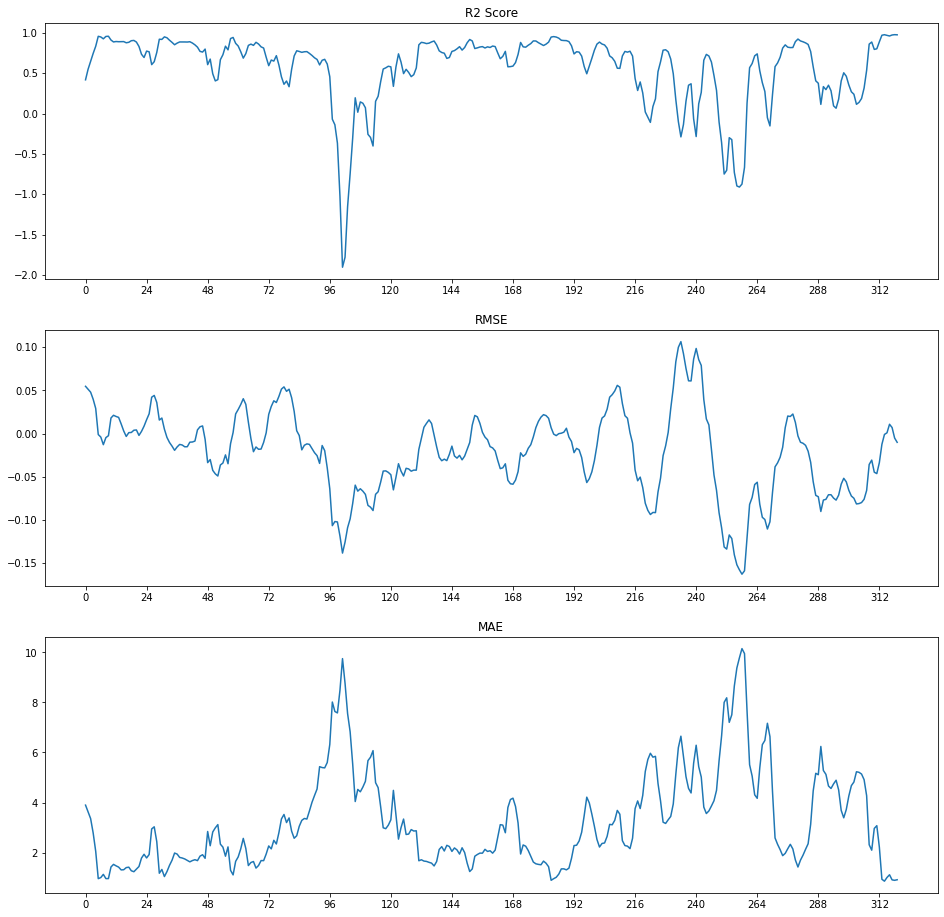

In [60]:
fig = plot_metrics(df_pred)

In [61]:
eval_df

,Prediction,Actual
2018-11-15 00:00:00+01:00,59.269759,59.530
2018-11-15 01:00:00+01:00,56.837361,57.336
2018-11-15 02:00:00+01:00,54.778637,55.770
2018-11-15 03:00:00+01:00,53.977226,55.086
2018-11-15 04:00:00+01:00,55.233187,57.688
...,...,...
2018-11-29 02:00:00+01:00,54.954024,53.662
2018-11-29 03:00:00+01:00,53.430272,52.358
2018-11-29 04:00:00+01:00,54.518798,53.764
2018-11-29 05:00:00+01:00,58.151889,56.792


Comparing to Benchmark

In [62]:
def extend_eval_df_benchmark(eval_df,bench_df):
    bench_df=bench_df[eval_df.index]
    extended_eval_df = pd.concat([eval_df,bench_df],axis=1)
    return extended_eval_df

In [63]:
extended_eval_df = extend_eval_df_benchmark(eval_df,bench_df)
extended_eval_df

NameError: name 'bench_df' is not defined

In [ ]:
r2_bench = r2_score(extended_eval_df['Actual'],extended_eval_df['Benchmark'],)
print('R^2 score is  %3.2f' %r2_bench)

In [ ]:
r2_test = r2_score(extended_eval_df['Actual'], extended_eval_df['Prediction'])
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
df_pred_24h = df_pred.iloc[:,0::24]
df_pred_24h['total'] = df_pred_24h.mean(axis=1)


In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(extended_eval_df['Actual'],label = 'Actual')
plt.plot(extended_eval_df['Prediction'], label= f'Prediction R^2 score: {round(r2_test,2)}')
plt.plot(extended_eval_df['Benchmark'], label = f'Benchmark R^2 score: {round(r2_bench,2)}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.title('Averaged Prediction with 24h horizon for 14 days')
plt.legend()
# plt.xlim(idx_test[0],idx_test[0]+timedelta(hours=24*14-1))